### AUTHOR : VAISHNAV KRISHNA P
#### Dataset Link : https://www.github.com/vaishnavgithuber
#### Dataset Info : This dataset contains resource utilization metrics collected over time to analyze and predict system performance. The data includes information on CPU utilization, memory usage, storage usage, workload, and timestamped features such as day, hour, and month. Additional engineered features, including sinusoidal transformations of time variables and rolling statistics, provide insights into temporal patterns and trends. The dataset is useful for performance analysis, workload prediction, and resource management in distributed or cloud computing systems.

#### IMPORTING LIBRARIES

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

#### DATASET LOADING

In [3]:
# Load the dataset
data = pd.read_csv("Resource_utilization.csv")

# Display the first few rows
data.head()

,timestamp,cpu_utilization,memory_usage,storage_usage,workload,Resource Allocation
0,2024-05-15 06:00:00,93.667656,65.739742,81.202149,100.00000,76.398051
1,2022-03-20 00:00:00,NaN,45.771232,56.178079,96.20153,52.783747
2,2024-03-31 02:00:00,66.270283,85.537221,61.594411,100.00000,71.699889
3,2022-10-05 07:00:00,50.305590,55.492008,100.419747,100.00000,69.456805
4,2022-07-18 08:00:00,58.567954,77.339342,60.446444,100.00000,66.624977


#### DATA PREPROCESSING
Steps in Data Preprocessing
1. Load Dataset: Load your dataset using pd.read_csv().
2. Missing Values: Use .isnull().sum() to check for missing values. In this case, we fill missing values with the column mean (fillna()).
3. Timestamp Conversion: Convert the timestamp column to datetime using pd.to_datetime(), allowing for temporal analysis.

In [15]:
# Check for missing values
print(data.isnull().sum())

timestamp              0
cpu_utilization        0
memory_usage           0
storage_usage          0
workload               0
Resource Allocation    0
dtype: int64


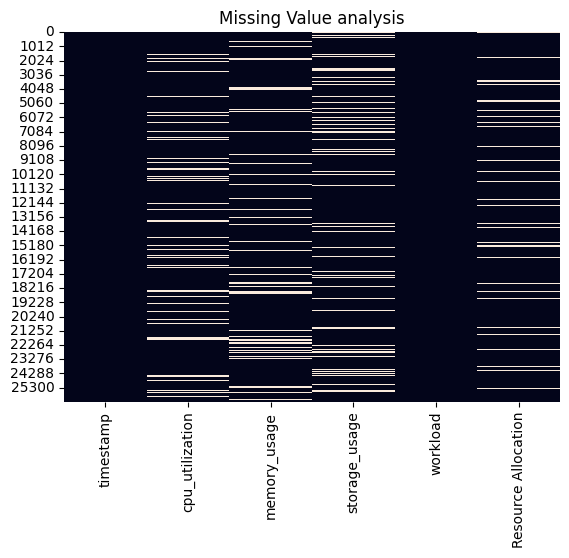

In [8]:
# Missing value analysis
plt.title("Missing Value analysis")
sns.heatmap(data.isna(), annot=False, cbar=False)
plt.show()

In [14]:
# Fill missing values - imputation method (forward fill, mean, etc.)
data['cpu_utilization'].fillna(data['cpu_utilization'].mean(), inplace=True)
data['memory_usage'].fillna(data['memory_usage'].mean(), inplace=True)
data['storage_usage'].fillna(data['storage_usage'].mean(), inplace=True)
data['workload'].fillna(data['workload'].mean(), inplace=True)
data['Resource Allocation'].fillna(data['Resource Allocation'].mean(), inplace=True)

#### FEATURE ENGINEERING
Feature Engineering Steps
1. We extract hour, day, month, and weekday from the timestamp.
2. To capture cyclical patterns (time of day, day of the week), we create sinusoidal and cosine features (this helps the model better learn periodic patterns like daily or weekly cycles).

In [17]:
# Convert 'timestamp' to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract temporal features
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['weekday'] = data['timestamp'].dt.weekday

# Add cyclical features for time-based columns (hour, weekday)
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday']/7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday']/7)

# Display the new features
data.head()

,timestamp,cpu_utilization,memory_usage,storage_usage,workload,Resource Allocation,hour,day,month,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
0,2024-05-15 06:00:00,93.667656,65.739742,81.202149,100.00000,76.398051,6,15,5,2,1.000000,6.123234e-17,0.974928,-0.222521
1,2022-03-20 00:00:00,53.206583,45.771232,56.178079,96.20153,52.783747,0,20,3,6,0.000000,1.000000e+00,-0.781831,0.623490
2,2024-03-31 02:00:00,66.270283,85.537221,61.594411,100.00000,71.699889,2,31,3,6,0.500000,8.660254e-01,-0.781831,0.623490
3,2022-10-05 07:00:00,50.305590,55.492008,100.419747,100.00000,69.456805,7,5,10,2,0.965926,-2.588190e-01,0.974928,-0.222521
4,2022-07-18 08:00:00,58.567954,77.339342,60.446444,100.00000,66.624977,8,18,7,0,0.866025,-5.000000e-01,0.000000,1.000000


#### EXPLORATIVE DATA ANALYSIS
Steps in EDA:
1. Histogram: Visualize the distribution of CPU utilization (you can repeat this for other features).
2. Pairplot: Visualize relationships between different features and the target (Resource Allocation).
3. Correlation Heatmap: See how correlated the features are with each other and with Resource Allocation.

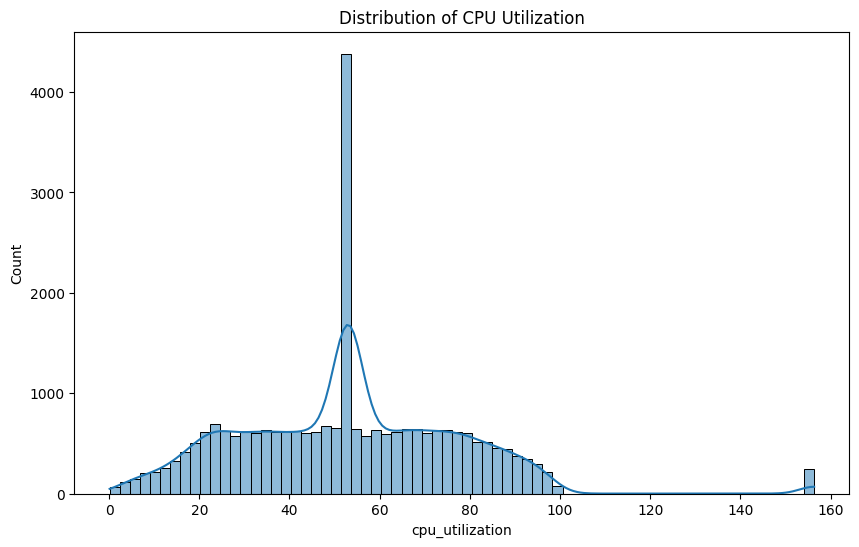

In [20]:
# Plot CPU utilization distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['cpu_utilization'], kde=True)
plt.title("Distribution of CPU Utilization")
plt.show()

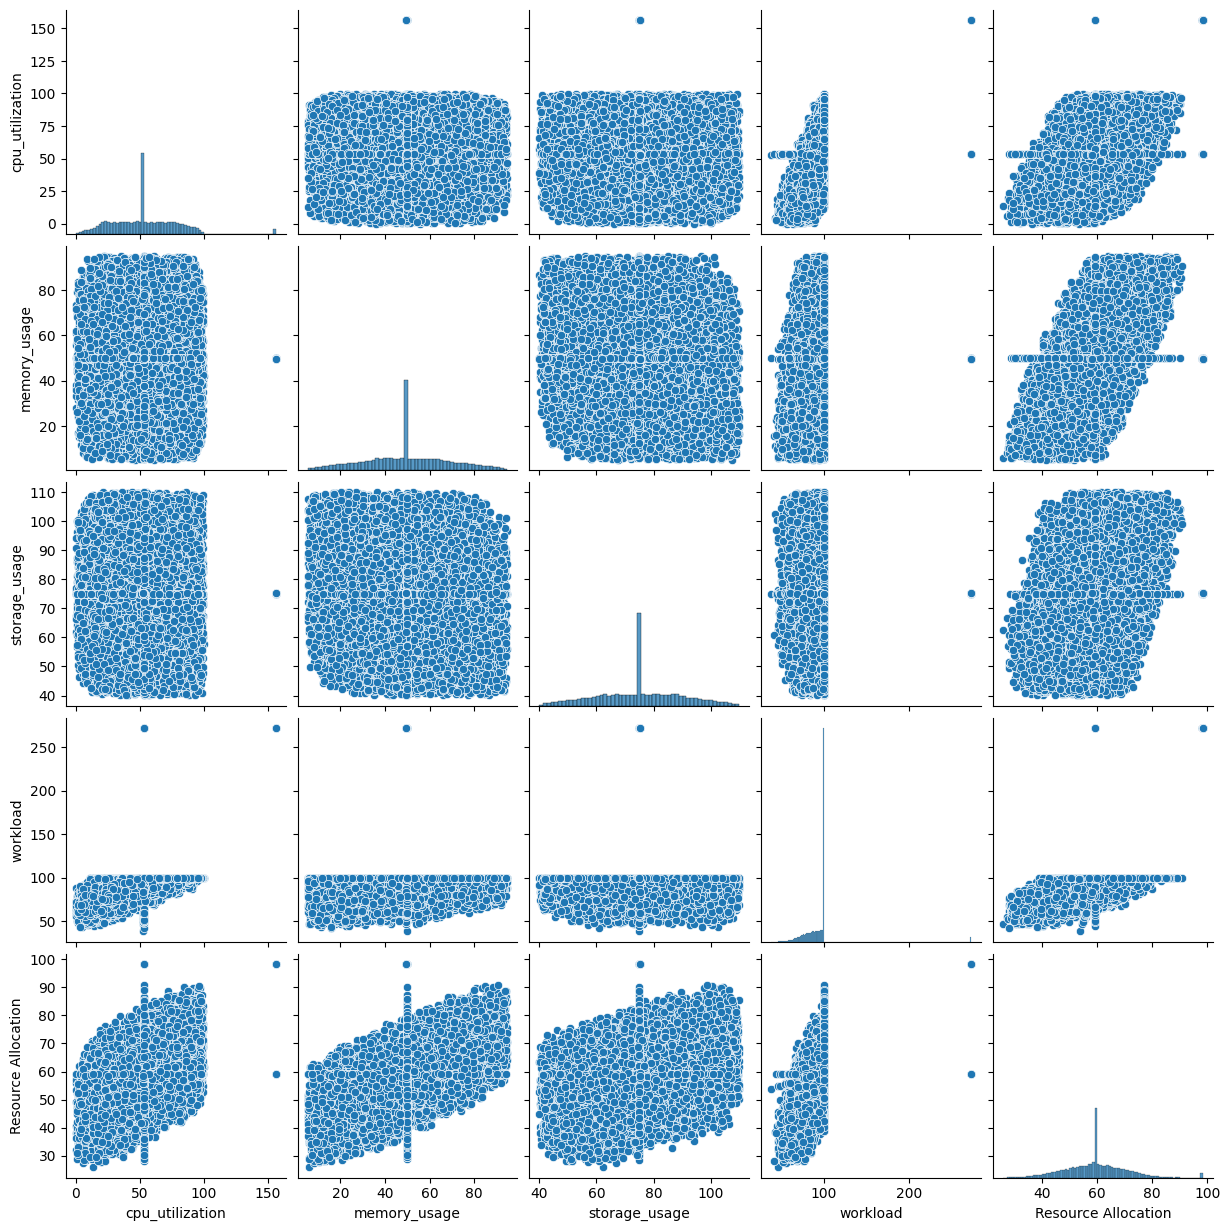

In [21]:
# Plot relationship between features and resource allocation
sns.pairplot(data[['cpu_utilization', 'memory_usage', 'storage_usage', 'workload', 'Resource Allocation']])
plt.show()

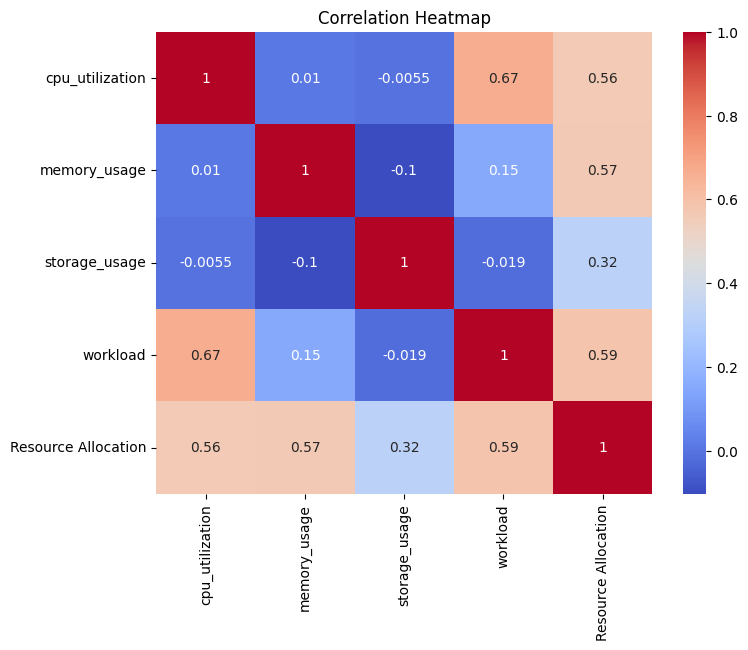

In [22]:
# Correlation heatmap
corr_matrix = data[['cpu_utilization', 'memory_usage', 'storage_usage', 'workload', 'Resource Allocation']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#### Model Building & Evaluation
1. Train-Test Split: Split the dataset into training and testing sets using train_test_split().
2. Model Training: Train Linear Regression, Random Forest, and XGBoost models on the data.
Evaluation: Use MAE, RMSE, and R² to evaluate each model's performance.

In [23]:
# Define features and target
X = data[['cpu_utilization', 'memory_usage', 'storage_usage', 'workload', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
y = data['Resource Allocation']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# 3. XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluate models
def evaluate_model(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

# Linear Regression Evaluation
lr_mae, lr_rmse, lr_r2 = evaluate_model(y_test, lr_predictions)

# Random Forest Evaluation
rf_mae, rf_rmse, rf_r2 = evaluate_model(y_test, rf_predictions)

# XGBoost Evaluation
xgb_mae, xgb_rmse, xgb_r2 = evaluate_model(y_test, xgb_predictions)

# Print the results
print(f"Linear Regression - MAE: {lr_mae}, RMSE: {lr_rmse}, R²: {lr_r2}")
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}, R²: {rf_r2}")
print(f"XGBoost - MAE: {xgb_mae}, RMSE: {xgb_rmse}, R²: {xgb_r2}")

Linear Regression - MAE: 2.711384016954822, RMSE: 4.582543077052311, R²: 0.8131357418475835
Random Forest - MAE: 2.741652211058608, RMSE: 4.456094502491612, R²: 0.8233059546373263
XGBoost - MAE: 2.746701003717707, RMSE: 4.503201151309841, R²: 0.8195504421817605


#### Interpretation:
1. R² values of around 0.81–0.82 are quite good. This means that the models are explaining about 81% to 82% of the variance in the resource allocation.
2. MAE and RMSE values are reasonably low, indicating that the model's errors are not excessively large.
3. Random Forest and XGBoost perform similarly, with Random Forest slightly outperforming XGBoost in terms of R², MAE, and RMSE.


#### RESULT CHARTS
1. Model Performance Comparison Bar Chart

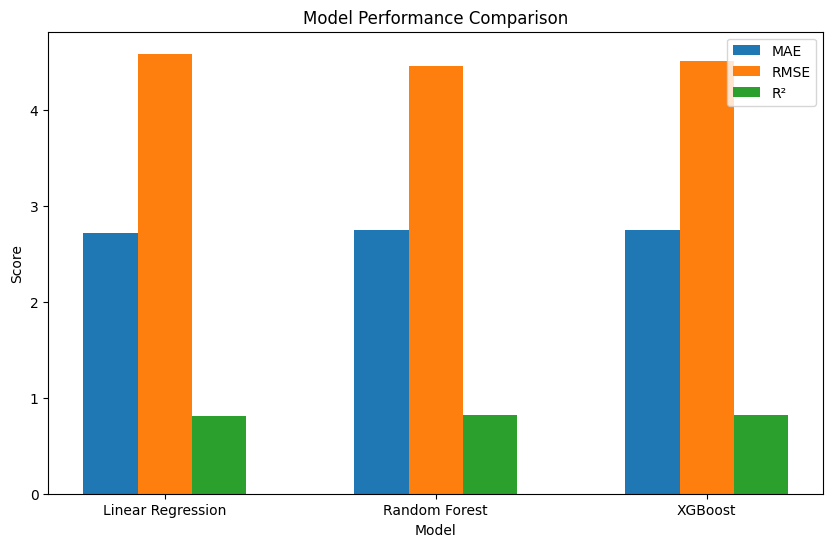

In [35]:
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mae = [lr_mae, rf_mae, xgb_mae]
rmse = [lr_rmse, rf_rmse, xgb_rmse]
r2 = [lr_r2, rf_r2, xgb_r2]

x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 0.2, mae, 0.2, label='MAE')
ax.bar(x, rmse, 0.2, label='RMSE')
ax.bar(x + 0.2, r2, 0.2, label='R²')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

2. Feature Importance Plot (Random Forest & XGBoost)

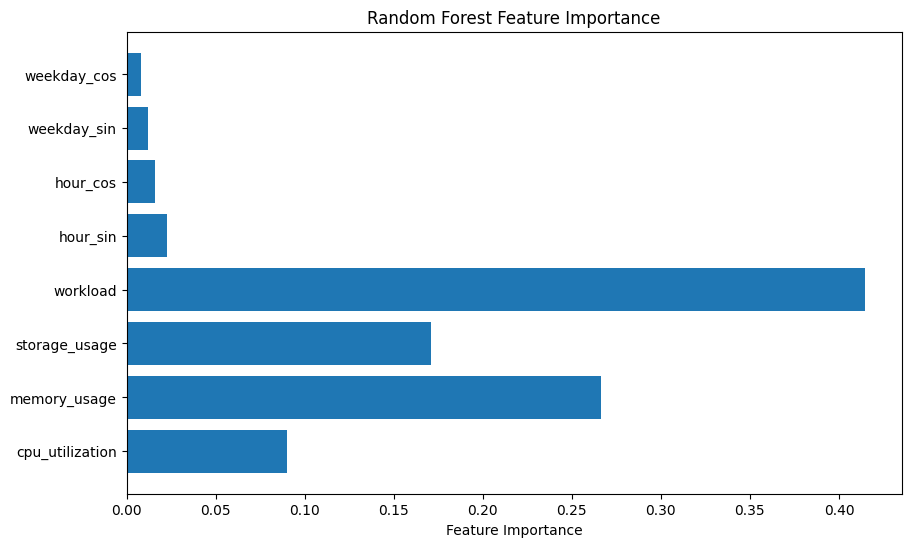

In [38]:
# Feature importance for Random Forest
rf_importance = rf_model.feature_importances_
features = X.columns

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, rf_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

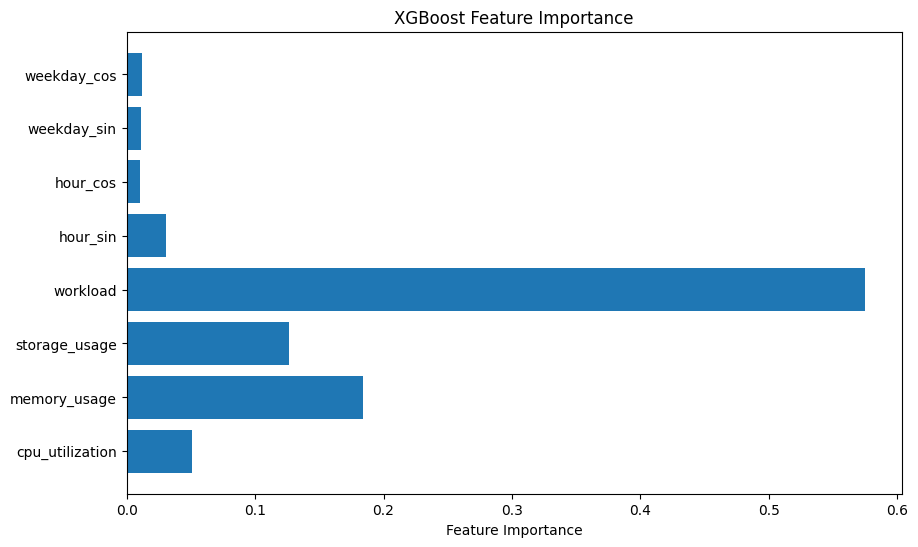

In [36]:
# Feature importance for XGBoost
xgb_importance = xgb_model.feature_importances_

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, xgb_importance)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

3. Prediction Vs Actual

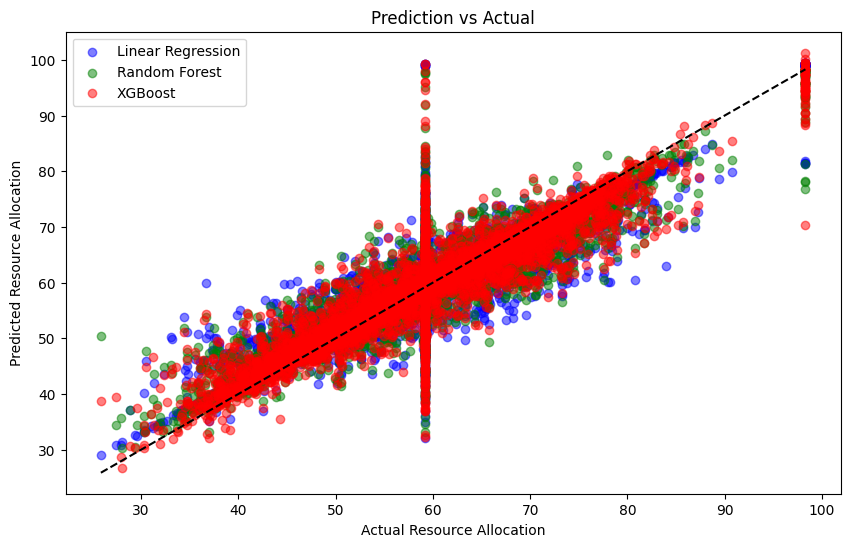

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, color='blue', label='Linear Regression', alpha=0.5)
plt.scatter(y_test, rf_predictions, color='green', label='Random Forest', alpha=0.5)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel('Actual Resource Allocation')
plt.ylabel('Predicted Resource Allocation')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

4. Residual plot

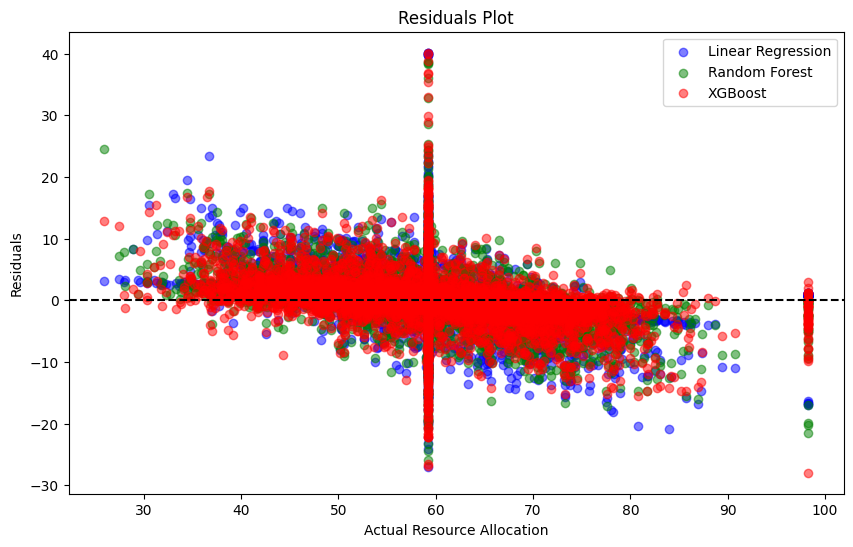

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions - y_test, color='blue', label='Linear Regression', alpha=0.5)
plt.scatter(y_test, rf_predictions - y_test, color='green', label='Random Forest', alpha=0.5)
plt.scatter(y_test, xgb_predictions - y_test, color='red', label='XGBoost', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Actual Resource Allocation')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.show()

5. Box Plot of Model Errors

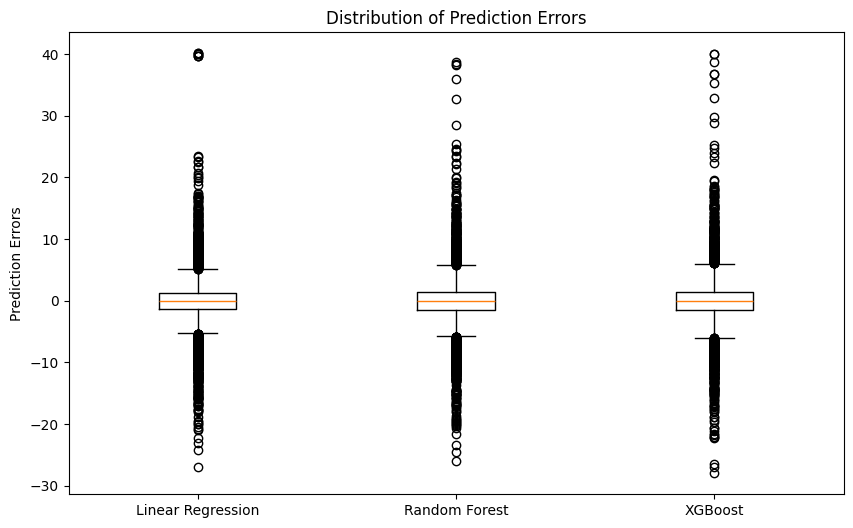

In [30]:
errors_lr = lr_predictions - y_test
errors_rf = rf_predictions - y_test
errors_xgb = xgb_predictions - y_test

plt.figure(figsize=(10, 6))
plt.boxplot([errors_lr, errors_rf, errors_xgb], labels=['Linear Regression', 'Random Forest', 'XGBoost'])
plt.ylabel('Prediction Errors')
plt.title('Distribution of Prediction Errors')
plt.show()

6. Heatmap of Model Evaluation Metrics

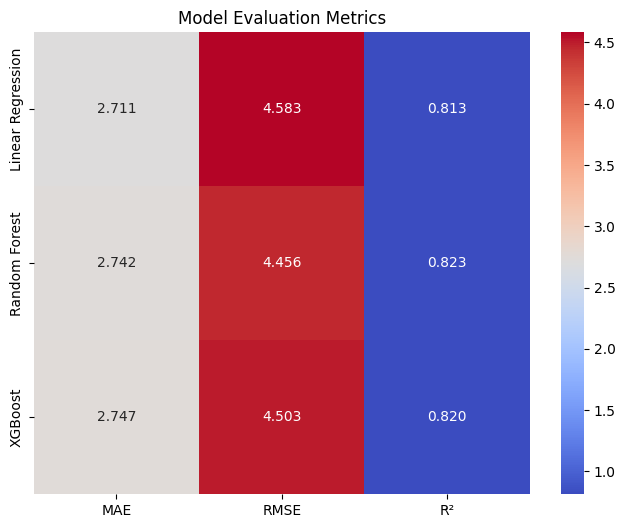

In [31]:
metrics = np.array([[lr_mae, lr_rmse, lr_r2],
                    [rf_mae, rf_rmse, rf_r2],
                    [xgb_mae, xgb_rmse, xgb_r2]])

metrics_df = pd.DataFrame(metrics, columns=['MAE', 'RMSE', 'R²'], index=['Linear Regression', 'Random Forest', 'XGBoost'])

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Model Evaluation Metrics')
plt.show()

7. Cumulative Distribution Function (CDF) of Resource Allocation

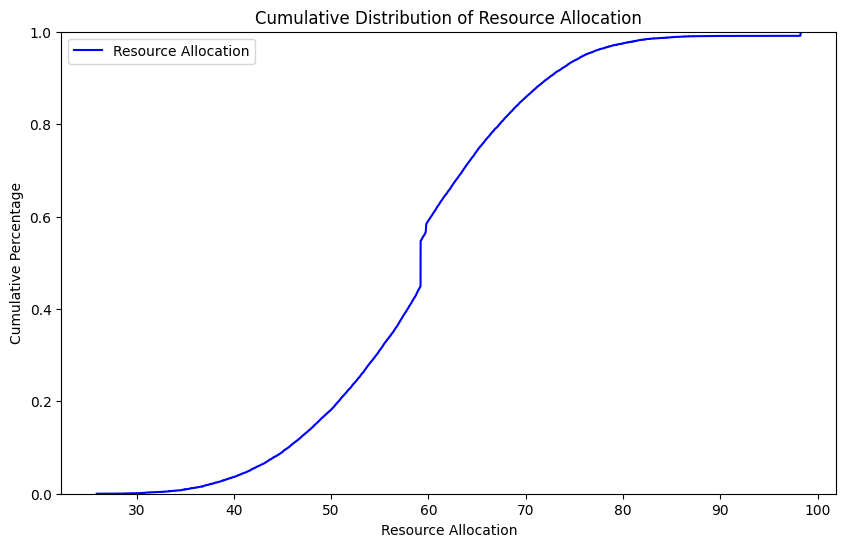

In [32]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data['Resource Allocation'], color='blue', label='Resource Allocation')
plt.xlabel('Resource Allocation')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Resource Allocation')
plt.legend()
plt.show()